### Finding Threshold for Notch Filter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne
from mne.decoding import Scaler
from mne_features.univariate import compute_pow_freq_bands
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from utils import *

In [2]:
mne.set_log_level('WARNING')

In [3]:
df = pd.read_csv('by_patient.csv')

other_df = activity_df(df, 'Other', 'expert_consensus')
seizure_df = activity_df(df, 'Seizure', 'expert_consensus')
lpd_df = activity_df(df, 'LPD', 'expert_consensus')
gpd_df = activity_df(df, 'GPD', 'expert_consensus')
lrda_df = activity_df(df, 'LRDA', 'expert_consensus')
grda_df = activity_df(df, 'GRDA', 'expert_consensus')

In [4]:
activity_df_list = [other_df, seizure_df, gpd_df, lpd_df, grda_df, lrda_df]

In [5]:
i_vals = [i for i in range(df.shape[0])]

In [9]:
raw1 = load_preprocess(df, 700, 1, None, 0.02, 1.061, bandpass = True, reref = False)
raw2 = load_preprocess(df, 200, 1, None, 0.02, 1.061, bandpass = True, reref = False)

These are derived from the notebook **Finding Threshold for Notch Filter**. They're quantiles 0.1, 0.2, 0.3,..., 0.9.

In [6]:
thresholds = [0.003, 0.009, 0.02, 0.049, 0.126, 0.245, 0.463, 1.061, 2.6801]

### Ensuring Functions Work  
  
I added a function that calculates the average peak to peak between 59 Hz and 61 Hz for the power spectrum of every sub EEG. If the average ptp for a sub EEG is above the specified threshold, then that sub EEG will be spectrum fit notch filtered. If it isn't above the threshold, that sub EEG will not be notch filtered.

/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/home/clay/.local/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


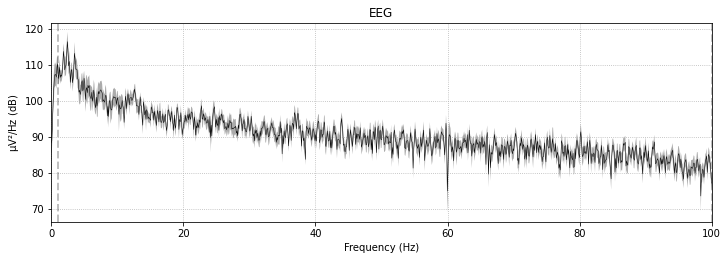

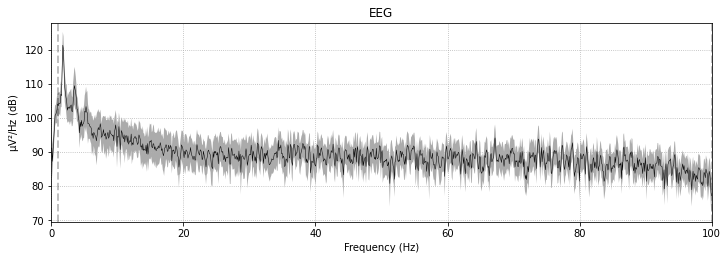

In [11]:
raw1.plot_psd(average = True, picks = 'eeg')
raw2.plot_psd(average = True, picks = 'eeg')
plt.show()

### No Notch, No Lowpass

In [17]:
#no_lowpass_df = full_band_df(2000, activity_df_list, 1, None, 50, bandpass = True, reref = False)
#no_lowpass_df.to_csv('no_lowpass_df.csv', index = None)

In [7]:
X = pd.read_csv('no_lowpass_df.csv')
y = get_yvals(2000)['activity']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (No Notch, No Lowpass)')
print(classification_report(y_train, training_yhat))
print('Testing (No Notch, No Lowpass)')
print(classification_report(y_test, testing_yhat))

Training (No Notch, No Lowpass)
              precision    recall  f1-score   support

         GPD       0.81      0.92      0.86      1794
        GRDA       0.75      0.88      0.81      1819
         LPD       0.78      0.86      0.81      1800
        LRDA       0.80      0.89      0.84      1795
       Other       0.76      0.56      0.65      1808
     Seizure       0.87      0.62      0.72      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing (No Notch, No Lowpass)
              precision    recall  f1-score   support

         GPD       0.73      0.82      0.78       206
        GRDA       0.59      0.78      0.67       181
         LPD       0.61      0.72      0.67       200
        LRDA       0.74      0.80      0.77       205
       Other       0.50      0.37      0.42       192
     Seizure       0.76      0.45      0.57       216

    accuracy  

In [10]:
baseline_acc = accuracy_score(y_test, testing_yhat)
baseline_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
baseline_f1 = f1_score(y_test, testing_yhat, average = None)

### 30th Percentile  
  
Any sub EEG with an average spectral ptp between 59 Hz and 61 Hz above the 30th percentile (0.002) will be notch filtered using the spectrum fit method.

In [11]:
#features_ptp30 = full_band_df(2000, activity_df_list, 1, None, 0.002, bandpass = True, reref = False)
#features_ptp30.to_csv('features_ptp30.csv', index = None)

In [12]:
X = pd.read_csv('features_ptp30.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (PTP 30th Percentile)')
print(classification_report(y_train, training_yhat))
print('Testing (PTP 30th Percentile)')
print(classification_report(y_test, testing_yhat))

Training (PTP 30th Percentile)
              precision    recall  f1-score   support

         GPD       0.77      0.93      0.84      1794
        GRDA       0.72      0.87      0.79      1819
         LPD       0.74      0.84      0.79      1800
        LRDA       0.82      0.86      0.84      1795
       Other       0.75      0.54      0.63      1808
     Seizure       0.88      0.58      0.70      1784

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.76     10800
weighted avg       0.78      0.77      0.76     10800

Testing (PTP 30th Percentile)
              precision    recall  f1-score   support

         GPD       0.64      0.81      0.71       206
        GRDA       0.61      0.79      0.69       181
         LPD       0.64      0.76      0.69       200
        LRDA       0.74      0.74      0.74       205
       Other       0.50      0.33      0.40       192
     Seizure       0.80      0.50      0.61       216

    accuracy    

In [14]:
threshold30_acc = accuracy_score(y_test, testing_yhat)
threshold30_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
threshold30_f1 = f1_score(y_test, testing_yhat, average = None)

### Notes  
  
Results basically equivalent. The lack of affect is odd. It wouldn't surprise me if a number of these approaches hurt performance, but there being such little difference between the performance of so many different approaches is something I don't know how to explain.  
  
### 40th Percentile

In [15]:
#features_ptp40 = full_band_df(2000, activity_df_list, 1, None, 0.049, bandpass = True, reref = False)
#features_ptp40.to_csv('features_ptp40.csv', index = None)

In [16]:
X = pd.read_csv('features_ptp40.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [17]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (PTP 40th Percentile)')
print(classification_report(y_train, training_yhat))
print('Testing (PTP 40th Percentile)')
print(classification_report(y_test, testing_yhat))

Training (PTP 40th Percentile)
              precision    recall  f1-score   support

         GPD       0.77      0.93      0.85      1794
        GRDA       0.74      0.88      0.80      1819
         LPD       0.74      0.85      0.79      1800
        LRDA       0.82      0.87      0.84      1795
       Other       0.72      0.53      0.61      1808
     Seizure       0.88      0.58      0.69      1784

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.76     10800
weighted avg       0.78      0.77      0.76     10800

Testing (PTP 40th Percentile)
              precision    recall  f1-score   support

         GPD       0.68      0.81      0.74       206
        GRDA       0.59      0.77      0.67       181
         LPD       0.59      0.67      0.62       200
        LRDA       0.72      0.79      0.75       205
       Other       0.57      0.39      0.46       192
     Seizure       0.75      0.47      0.58       216

    accuracy    

In [18]:
threshold40_acc = accuracy_score(y_test, testing_yhat)
threshold40_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
threshold40_f1 = f1_score(y_test, testing_yhat, average = None)

### 50th Percentile

In [19]:
#features_ptp50 = full_band_df(2000, activity_df_list, 1, None, 0.126, bandpass = True, reref = False)
#features_ptp50.to_csv('features_ptp50.csv', index = None)

In [20]:
X = pd.read_csv('features_ptp50.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (PTP 50th Percentile)')
print(classification_report(y_train, training_yhat))
print('Testing (PTP 50th Percentile)')
print(classification_report(y_test, testing_yhat))

Training (PTP 50th Percentile)
              precision    recall  f1-score   support

         GPD       0.79      0.93      0.85      1794
        GRDA       0.75      0.89      0.82      1819
         LPD       0.73      0.86      0.79      1800
        LRDA       0.84      0.86      0.85      1795
       Other       0.75      0.56      0.64      1808
     Seizure       0.89      0.62      0.73      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing (PTP 50th Percentile)
              precision    recall  f1-score   support

         GPD       0.69      0.87      0.77       206
        GRDA       0.56      0.75      0.64       181
         LPD       0.65      0.80      0.72       200
        LRDA       0.72      0.79      0.75       205
       Other       0.44      0.29      0.35       192
     Seizure       0.78      0.38      0.51       216

    accuracy    

In [22]:
threshold50_acc = accuracy_score(y_test, testing_yhat)
threshold50_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
threshold50_f1 = f1_score(y_test, testing_yhat, average = None)

### 90th Percentile (Default FIR)

In [23]:
#features_ptp90 = full_band_df(2000, activity_df_list, 1, None, 2.6801, bandpass = True, reref = False)
#features_ptp90.to_csv('features_ptp90.csv', index = None)

In [24]:
X = pd.read_csv('features_ptp90.csv')
y = get_yvals(2000)['activity']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (PTP 90th Percentile)')
print(classification_report(y_train, training_yhat))
print('Testing (PTP 90th Percentile)')
print(classification_report(y_test, testing_yhat))

Training (PTP 90th Percentile)
              precision    recall  f1-score   support

         GPD       0.81      0.92      0.86      1794
        GRDA       0.74      0.88      0.80      1819
         LPD       0.75      0.87      0.80      1800
        LRDA       0.81      0.87      0.84      1795
       Other       0.75      0.55      0.63      1808
     Seizure       0.88      0.63      0.74      1784

    accuracy                           0.79     10800
   macro avg       0.79      0.79      0.78     10800
weighted avg       0.79      0.79      0.78     10800

Testing (PTP 90th Percentile)
              precision    recall  f1-score   support

         GPD       0.72      0.82      0.77       206
        GRDA       0.57      0.77      0.66       181
         LPD       0.62      0.76      0.68       200
        LRDA       0.76      0.78      0.77       205
       Other       0.56      0.33      0.41       192
     Seizure       0.75      0.52      0.61       216

    accuracy    

In [26]:
threshold90_acc = accuracy_score(y_test, testing_yhat)
threshold90_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
threshold90_f1 = f1_score(y_test, testing_yhat, average = None)

### 80th Percentile (Default FIR)

In [27]:
#features_ptp80 = full_band_df(2000, activity_df_list, 1, None, 1.061, bandpass = True, reref = False)
#features_ptp80.to_csv('features_ptp80.csv', index = None)

In [28]:
X = pd.read_csv('features_ptp80.csv')

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (PTP 80th Percentile)')
print(classification_report(y_train, training_yhat))
print('Testing (PTP 80th Percentile)')
print(classification_report(y_test, testing_yhat))

Training (PTP 80th Percentile)
              precision    recall  f1-score   support

         GPD       0.79      0.92      0.85      1794
        GRDA       0.74      0.88      0.80      1819
         LPD       0.74      0.86      0.80      1800
        LRDA       0.82      0.87      0.84      1795
       Other       0.75      0.54      0.63      1808
     Seizure       0.87      0.60      0.71      1784

    accuracy                           0.78     10800
   macro avg       0.78      0.78      0.77     10800
weighted avg       0.78      0.78      0.77     10800

Testing (PTP 80th Percentile)
              precision    recall  f1-score   support

         GPD       0.73      0.83      0.77       206
        GRDA       0.60      0.76      0.67       181
         LPD       0.60      0.75      0.67       200
        LRDA       0.74      0.83      0.78       205
       Other       0.55      0.36      0.44       192
     Seizure       0.79      0.48      0.60       216

    accuracy    

In [30]:
threshold80_acc = accuracy_score(y_test, testing_yhat)
threshold80_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
threshold80_f1 = f1_score(y_test, testing_yhat, average = None)

### Thresholds at 30th and 80th Percentiles  
  
No filtering below 30th percentile. Spectrum fit method between 30th percentile and 80th percentile. Default FIR filtering above 80th percentile.  
  
If this also has a negative affect or little to no affect on the results, I'm moving forward without notch filtering at all.

In [31]:
#features_ptp3080 = full_band_df(2000, activity_df_list, 1, None, 0.02, 1.061, bandpass = True, reref = False)
#features_ptp3080.to_csv('features_ptp3080.csv', index = None)

In [32]:
X = pd.read_csv('features_ptp3080.csv')
y = get_yvals(2000)['activity']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [33]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
training_yhat = knn.predict(X_train)
testing_yhat = knn.predict(X_test)
print('Training (PTP Between 30th and 80th Percentile)')
print(classification_report(y_train, training_yhat))
print('Testing (PTP Between 30th and 80th Percentile)')
print(classification_report(y_test, testing_yhat))

Training (PTP Between 30th and 80th Percentile)
              precision    recall  f1-score   support

         GPD       0.78      0.93      0.85      1794
        GRDA       0.72      0.87      0.79      1819
         LPD       0.75      0.85      0.80      1800
        LRDA       0.82      0.86      0.84      1795
       Other       0.75      0.55      0.64      1808
     Seizure       0.88      0.61      0.72      1784

    accuracy                           0.78     10800
   macro avg       0.78      0.78      0.77     10800
weighted avg       0.78      0.78      0.77     10800

Testing (PTP Between 30th and 80th Percentile)
              precision    recall  f1-score   support

         GPD       0.70      0.89      0.79       206
        GRDA       0.61      0.80      0.69       181
         LPD       0.61      0.74      0.67       200
        LRDA       0.71      0.73      0.72       205
       Other       0.49      0.37      0.42       192
     Seizure       0.80      0.37    

In [34]:
threshold3080_acc = accuracy_score(y_test, testing_yhat)
threshold3080_macro_f1 = f1_score(y_test, testing_yhat, average = 'macro')
threshold3080_f1 = f1_score(y_test, testing_yhat, average = None)

In [35]:
testing_accuracies = [baseline_acc, threshold30_acc, threshold40_acc, threshold50_acc,
                      threshold80_acc, threshold90_acc, threshold3080_acc]

In [36]:
testing_macro_f1s = [baseline_macro_f1, threshold30_macro_f1, threshold40_macro_f1, threshold50_macro_f1,
                      threshold80_macro_f1, threshold90_macro_f1, threshold3080_macro_f1]

In [37]:
testing_activity_f1s = [baseline_f1, threshold30_f1, threshold40_f1, threshold50_f1,
                      threshold80_f1, threshold90_f1, threshold3080_f1]

In [39]:
pd.DataFrame(testing_accuracies,
             index = ['No Filter', 'SpecFit 30%ile', 'SpecFit 40%ile', 'SpecFit 50%ile', 'FIR 80%ile', 'FIR 90%ile', 'Combined 30%ile 80%ile'],
             columns = ['Accuracy'])

,Accuracy
No Filter,0.656667
SpecFit 30%ile,0.652500
SpecFit 40%ile,0.647500
SpecFit 50%ile,0.643333
FIR 80%ile,0.668333
FIR 90%ile,0.663333
Combined 30%ile 80%ile,0.647500


In [41]:
pd.DataFrame(testing_macro_f1s,
             index = ['No Filter', 'SpecFit 30%ile', 'SpecFit 40%ile', 'SpecFit 50%ile', 'FIR 80%ile', 'FIR 90%ile', 'Combined 30%ile 80%ile'],
             columns = ['Macro F1'])

,Macro F1
No Filter,0.644818
SpecFit 30%ile,0.640401
SpecFit 40%ile,0.637208
SpecFit 50%ile,0.623195
FIR 80%ile,0.655262
FIR 90%ile,0.649984
Combined 30%ile 80%ile,0.631401


In [44]:
pd.DataFrame(testing_activity_f1s,
             index = ['No Filter', 'SpecFit 30%ile', 'SpecFit 40%ile', 'SpecFit 50%ile', 'FIR 80%ile', 'FIR 90%ile', 'Combined 30%ile 80%ile'],
             columns = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'])

,GPD,GRDA,LPD,LRDA,Other,Seizure
No Filter,0.775229,0.669834,0.665138,0.769231,0.423881,0.565598
SpecFit 30%ile,0.713675,0.687500,0.692661,0.738386,0.398754,0.611429
SpecFit 40%ile,0.738938,0.668269,0.622951,0.750583,0.462963,0.579545
SpecFit 50%ile,0.771552,0.638298,0.717833,0.750583,0.350000,0.510903
FIR 80%ile,0.772727,0.671533,0.668151,0.784404,0.435331,0.599424
FIR 90%ile,0.768182,0.655738,0.681614,0.769231,0.413115,0.612022
Combined 30%ile 80%ile,0.785408,0.690476,0.669663,0.721154,0.420118,0.501587


### Conclusion  
  
There may be an effective way to go about notch filtering to handle power line noise. I haven't found it. My inclination is say that the variability with this artifact EEG to EEG is too high to use the same filtering method and parameters on large sets of EEGs. It needs to be done in a more individualized way. In other words, each EEG needs to be handled individually. The above attempts were intended to improve results by determining how extreme the artifact at 60 Hz was, group EEGs by severity of power line noise, and then use different notch filtering approaches with each group. That was unsuccessful. Maybe there's a way to make these groups smaller and use even more finely tuned parameters for the different notch filters, but I don't have the time to explore that possibility. It's time to move on to re-referencing and then attempting to handle ECG artifacts with ICA.  
  
I do want to mention again how little these results are changing. The results are basically equivalent despite the difference from feature set to feature set in the notch filtering approach. I would expect more change in results, even if results got worse. Results not budging confuses me. I'm not sure what the explanation. If the results were more even across activity types and closer to what you'd see from randomly guessing, it would be easier to conclude that the feature data is ineffective. The reality is that categories like "Other" and "Seizure" are consistently the worst performing categories which is what I would expect given the nature of those two categories. THe other four categories perform show much better results with each run of a model. The model does seem to be identifying some pattern in the data which allows it to perform better than random guessing and also allows it to perform better with some categories of brain activity than with others.